In [1]:
import sys
sys.path.append("../code")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scale_bar import add_scalebar
#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{lmodern}']

from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from scipy.io import savemat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)

from sklearn.datasets import make_moons

from scipy.spatial import procrustes

dataset = 2
import mnist_reader 
    
X_train, y_train = mnist_reader.load_mnist('../data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('../data/fashion', kind='t10k')

#n = 2000
#np.random.seed(6333)
#ids = np.random.choice(range(60000),n, replace=False)
#X_train, y_train = X_train[ids], y_train[ids]

X_train = X_train.astype(np.float32)
max_val = np.max(X_train)
X_train = X_train/max_val

X_test = X_test/max_val

n = X_train.shape[0]

classes = [
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9']

classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

print(X_train.shape, y_train.shape, X_train.dtype)

#Torch Setups
from sklearn.decomposition import PCA

#import torch
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#X_torch = torch.as_tensor(X_train, dtype=torch.float32, device=device)

n_components = 2

pca = PCA(n_components = n_components)
x_init = pca.fit_transform(X_train)
x_init = x_init - np.mean(x_init, axis=0)

def print_stats(X):
    print('size: ', X.shape)
    print('Mean:', np.mean(X))
    print('Max: ', np.max(X))
    print('Min: ', np.min(X))
    print('STD: ', np.std(X))
    
    return

print('Training Statistics')
print_stats(X_train)
#print('Test Statistics')
#print_stats(X_test)


epochs = 200
n_neighbors= 15
n_components = 2
MIN_DIST = 0.1

    
%matplotlib notebook
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(60000, 784) (60000,) float32
Training Statistics
size:  (60000, 784)
Mean: 0.2860402
Max:  1.0
Min:  0.0
STD:  0.3530239


In [2]:
from scale_bar import add_scalebar
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
from matplotlib.offsetbox import HPacker, TextArea

def plot_idxs(array,idxs,title=None, values = None, tick_off=True):
    
    plt.figure()
    
    if title is not None:
        plt.title(title)
        
    n_plot = int(np.sqrt(len(idxs)))
    
    for i in range(n_plot**2):
        ax = plt.subplot(n_plot, n_plot, i+1)
        plt.scatter(array[idxs[i],:,0], array[idxs[i],:,1], c=y_train, s=0.01, cmap='Spectral')
        add_scalebar(ax, loc=4, barwidth=1, matchx=False, matchy=False, 
                     sizey=1, sizex=1, 
                     labelx='1.0', labely='1.0',
                    fontsize='xx-small',
                    hidex=True, hidey=True)
        
        
        if values is not None:
            val = r"$p_d=${:.3f}".format(values[i])
            plt.text(1.0, 1.0, val,
                     horizontalalignment='right',
                     verticalalignment='top',
                     transform = ax.transAxes)
        if tick_off:
            plt.xticks([])
            plt.yticks([])
        plt.axis('on')
        
    return

def plot_low_k_idxs(array, metric, k, title=None):

    idxs_arg = np.argpartition(metric, k)[:k]
    values = metric[idxs_arg]

    idxs_arg_pointer = np.argsort(values)

    values = values[idxs_arg_pointer]
    idxs_arg = idxs_arg[idxs_arg_pointer]

    plot_idxs(array, idxs_arg, title=title, values=values)
    
    return

def plot_high_k_idxs(array, metric, k, title=None):

    idxs_arg = np.argpartition(metric, -k)[-k:]
    values = metric[idxs_arg]

    idxs_arg_pointer = np.argsort(values)

    values = values[idxs_arg_pointer]
    idxs_arg = idxs_arg[idxs_arg_pointer]

    plot_idxs(array, idxs_arg, title=title, values=values)
    
    return

def my_procrustes(data1, data2):
    #adapted from https://github.com/scipy/scipy/blob/v1.11.2/scipy/spatial/_procrustes.py#L15-L131
    mtx1 = np.array(data1, dtype=np.double, copy=True)
    mtx2 = np.array(data2, dtype=np.double, copy=True)
    
    
    mtx1 -= np.mean(mtx1, 0)
    mtx2 -= np.mean(mtx2, 0)

    norm1 = np.linalg.norm(mtx1)
    norm2 = np.linalg.norm(mtx2)
    
    mtx1 /= norm1
    mtx2 /= norm2
    
    R, s = orthogonal_procrustes(mtx1, mtx2)
    mtx2 = np.dot(mtx2, R.T) * s
    
    disparity = np.sum(np.square(mtx1 - mtx2))
    
    mtx2 = np.dot(data2, R.T) #just get the rotation, reflection - and no scaling
    
    
    return disparity, mtx2

def procrustes_distances(standard_array, array, verbose=True): 
    pds = []
    X_pdx = []

    for i in range(len(array)):
        d,x_pd = my_procrustes(standard_array, array[i])
        pds.append(d)
        X_pdx.append(x_pd)

    pds = np.array(pds)
    X_pdx = np.array(X_pdx)
    if verbose:
        print('Procrusted Distance: Mean: ', np.mean(pds), ' STD: ', np.std(pds))
    
    return pds, X_pdx

def procrustes_matrix(standard_array, array):
    diagonal, X_pdx = procrustes_distances(standard_array, array)
    
    N = len(array)
    pd_mat = np.zeros((N,N))
    
    for i in range(N):
        row, _ = procrustes_distances(array[i], array, verbose=False)
        pd_mat[i,:] = row
    
    #print(np.diag(pd_mat))
    
    for i in range(N):
        pd_mat[i,i] = diagonal[i]
        
    return pd_mat, X_pdx

In [3]:
fname = 'random_init_test_orig'

with open('random_init_test_orig/fmnist_PCA_init.npy', 'rb') as f:
    umap_pca = np.load(f)
    
print(umap_pca.shape)

(60000, 2)


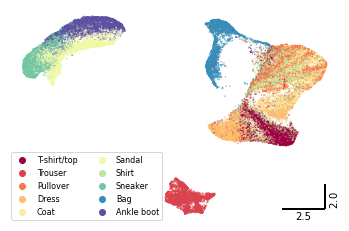

In [4]:
fig, ax = plt.subplots()

scatter = plt.scatter(umap_pca[:,0], umap_pca[:,1], c=y_train, s=0.1, alpha=1.0, cmap='Spectral')
plt.axis('off')

add_scalebar(ax, loc=4, barwidth=2)

lgd = plt.legend(*scatter.legend_elements(),
                    loc="lower left",
                    fontsize=20,
                 ncol=2,
                prop={'size': 8})
for j in range(len(lgd.get_texts())):
    lgd.get_texts()[j].set_text(classes[j])
    
plt.savefig('fig_random/standard_fminst_candle.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

<h1>Original UMAP</h1>

In [5]:
with open(fname+'/fmnist_random_init.npy', 'rb') as f:
    umap_r1 = np.load(f)
    
print(umap_r1.shape)

pd_r1, umap_pd_r1 = procrustes_distances(umap_pca, umap_r1)

print(umap_pd_r1.shape)

pd_mat, X_pdx = procrustes_matrix(umap_pca, umap_r1)

(100, 60000, 2)
Procrusted Distance: Mean:  0.572410038645165  STD:  0.18367808682929085
(100, 60000, 2)
Procrusted Distance: Mean:  0.572410038645165  STD:  0.18367808682929085


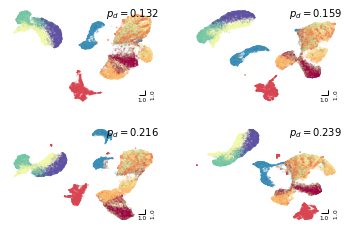

In [6]:
plot_low_k_idxs(umap_pd_r1,pd_r1,4)
plt.savefig('fig_random/fmnist_umap_random.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

In [7]:
np.argsort(pd_r1)

array([16, 49, 72, 32, 53, 80, 42, 87, 48, 43, 93, 31, 29,  2, 18, 75, 55,
       61, 36, 52, 28, 69, 37, 11,  3, 19, 88, 39, 57, 23, 91, 59, 66, 99,
       26, 58, 15,  6, 95, 85, 98, 73, 71, 56, 62, 54,  9, 24, 40, 96, 83,
       67, 25, 81, 90, 47, 12,  4, 51, 84, 13, 77, 21, 45, 20, 22, 44,  0,
       79, 41, 10, 70, 78, 30, 68, 64, 60, 92, 35, 76,  1, 94,  7, 17, 89,
       97,  5, 74, 33, 82, 65, 50, 86, 34, 63, 38, 27, 14, 46,  8])

[0.13200656 0.15873357 0.21633339 0.23944743 0.2648723  0.28907918
 0.31027257 0.31071891 0.31629304 0.33603213 0.3506689  0.3797352
 0.38439789 0.38604853 0.38605342 0.38991215 0.3985191  0.40390854
 0.40816194 0.41174371 0.4279801  0.42822861 0.4285559  0.43186645
 0.44646684 0.44996513 0.45260977 0.45852572 0.46503128 0.46583905
 0.47536417 0.47739613 0.48088368 0.48147997 0.48459022 0.48814866
 0.50988552 0.51100834 0.51163849 0.51945016 0.52198187 0.52568808
 0.54236242 0.54614353 0.54621404 0.54817146 0.55668523 0.56616646
 0.56706148 0.56793246 0.56937134 0.57229019 0.58116227 0.58674112
 0.58722871 0.5917838  0.59361783 0.60465041 0.60562344 0.6097387
 0.6131822  0.61626583 0.61926777 0.62073851 0.62654546 0.63136928
 0.6359146  0.63646876 0.64496756 0.64592743 0.64784655 0.64930933
 0.65090758 0.65423216 0.65759081 0.68023065 0.68551786 0.68714815
 0.70946032 0.71784907 0.73617818 0.7410913  0.75567218 0.7654231
 0.77622843 0.77650128 0.79293253 0.82430837 0.8369002  0.8452979

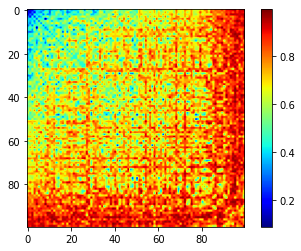

In [8]:
idx = np.argsort(np.diag(pd_mat))
pd_mat_2 = pd_mat[idx,:][:,idx]

plt.figure()
plt.imshow(pd_mat_2, cmap='jet')
plt.colorbar()

print(np.diag(pd_mat_2))

<h1>Modified Method</h1>

In [9]:
with open(fname+'/fmnist_random_init_model_1_0.5v2.npy', 'rb') as f:
    umap_mod = np.load(f)
    
print(umap_mod.shape)

pd_mod, umap_pd_mod = procrustes_distances(umap_pca, umap_mod)

print(umap_pd_mod.shape)

pd_mat_mod, X_pdx_mod = procrustes_matrix(umap_pca, umap_mod)

(100, 60000, 2)
Procrusted Distance: Mean:  0.27314378022786906  STD:  0.14927769542943878
(100, 60000, 2)
Procrusted Distance: Mean:  0.27314378022786906  STD:  0.14927769542943878


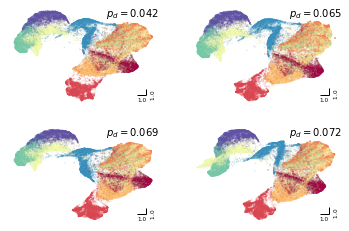

In [10]:
plot_low_k_idxs(umap_pd_mod,pd_mod,4)

plt.savefig('fig_random/fmnist_umap_mod_random.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

In [11]:
np.argsort(pd_mod)

array([43, 60, 15, 96, 55, 80, 73, 62,  5, 91, 54, 86, 16, 59, 30,  2, 21,
       39, 37, 24, 50, 11, 26, 78, 19, 58, 66, 94, 23, 93, 85,  3, 38, 22,
       27, 76, 84, 77, 25, 63, 10, 57, 71, 64, 35,  6, 40, 92,  7, 70, 14,
       36, 67, 18, 81, 69, 99, 29, 95, 45, 52, 33, 56, 44, 28, 82, 47,  9,
       41, 65, 90, 12, 17, 68, 51, 97, 48, 53,  1, 42, 61, 89,  8, 83, 87,
       49, 74, 34, 31, 20, 98, 13, 32,  0,  4, 72, 79, 46, 88, 75])

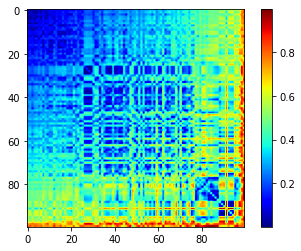

In [12]:
idx_mod = np.argsort(np.diag(pd_mat_mod))
pd_mat_2_mod = pd_mat_mod[idx_mod,:][:,idx_mod]

plt.figure()
plt.imshow(pd_mat_2_mod, cmap='jet')
plt.colorbar()

<h1>Composite Mod</h1>

In [13]:
with open(fname+'/fmnist_random_init_model_1_composite_v2.npy', 'rb') as f:
    umap_com = np.load(f)
    
print(umap_com.shape)

pd_com, umap_pd_com = procrustes_distances(umap_pca, umap_com)

print(umap_pd_com.shape)

pd_mat_com, X_pdx_com = procrustes_matrix(umap_pca, umap_com)

(100, 60000, 2)
Procrusted Distance: Mean:  0.31186891390707866  STD:  0.14831396803536356
(100, 60000, 2)
Procrusted Distance: Mean:  0.31186891390707866  STD:  0.14831396803536356


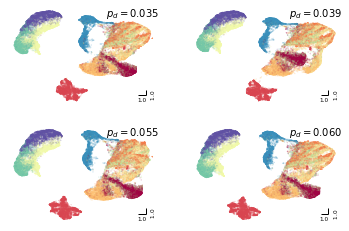

In [14]:
plot_low_k_idxs(umap_pd_com,pd_com,4)

plt.savefig('fig_random/fmnist_umap_com_random.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

In [15]:
np.argsort(pd_com)

array([48, 90, 85, 21, 44, 43, 70,  7, 42, 18, 56, 68, 57, 30, 67, 23, 39,
       41, 75, 95, 64, 80, 61, 79, 31, 52,  5, 71, 27, 91, 54,  8, 62, 37,
       98,  2, 16, 97, 32,  3, 34, 96, 76, 72, 19, 94, 50, 74, 63, 59, 65,
       69, 89, 58, 29, 99, 15, 33, 35, 17, 49, 25, 11, 81, 78, 93, 46, 22,
       88, 26, 55, 38, 84, 87, 77, 73, 82, 24,  6,  9, 60,  4, 40,  1, 12,
       92, 20, 66, 10, 83, 86, 13, 47, 53, 28, 36,  0, 51, 14, 45])

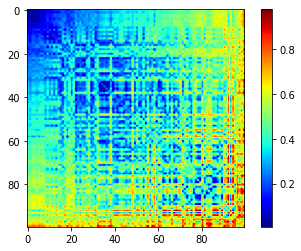

In [16]:
idx_com = np.argsort(np.diag(pd_mat_com))
pd_mat_2_com = pd_mat_com[idx_com,:][:,idx_com]

plt.figure()
plt.imshow(pd_mat_2_com, cmap='jet')
plt.colorbar()

In [17]:
min_val = np.floor(np.min(np.concatenate((pd_mat_2,pd_mat_2_mod,pd_mat_2_com))))
max_val = np.ceil(np.max(np.concatenate((pd_mat_2,pd_mat_2_mod,pd_mat_2_com))))

In [18]:
cmap = plt.cm.jet
norm = plt.Normalize(vmin=min_val, vmax=max_val)

pd_mat_2_image = cmap(norm(pd_mat_2))

print(pd_mat_2_image.shape)

plt.imsave('fig_random/fmnist_umap_random_pdmat.eps', pd_mat_2_image)

pd_mat_2_mod_image = cmap(norm(pd_mat_2_mod))
plt.imsave('fig_random/fmnist_umap_mod_random_pdmat.eps', pd_mat_2_mod_image)

pd_mat_2_com_image = cmap(norm(pd_mat_2_com))
plt.imsave('fig_random/fmnist_umap_com_random_pdmat.eps', pd_mat_2_com_image)


(100, 100, 4)


In [19]:
pd_mat_3 = pd_mat_2.copy()
np.fill_diagonal(pd_mat_3, 0)
z = pd_mat_3[pd_mat_3>0]
print('Original UMAP: ', np.mean(z), np.std(z))

pd_mat_3 = pd_mat_2_mod.copy()
np.fill_diagonal(pd_mat_3, 0)
z = pd_mat_3[pd_mat_3>0]
print('Modified UMAP:', np.mean(z), np.std(z))

pd_mat_3 = pd_mat_2_com.copy()
np.fill_diagonal(pd_mat_3, 0)
z = pd_mat_3[pd_mat_3>0]
print('Composite UMAP: ', np.mean(z), np.std(z))


Original UMAP:  0.7236991241339359 0.15380309503055634
Modified UMAP: 0.38323620547931647 0.1873030840639127
Composite UMAP:  0.42553796571902486 0.1764348123000994


<h1>Colorbar</h1>

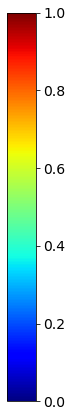

In [20]:
import pylab as pl
import numpy as np

a = np.array([[min_val,max_val]])
pl.figure(figsize=(0.5, 9))
img = pl.imshow(a, cmap="jet")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
cb = pl.colorbar(orientation="vertical", cax=cax)
#pl.savefig("colorbar.pdf")
cb.ax.tick_params(labelsize=14)
pl.savefig("fig_random/colorbar.svg", dpi=400, bbox_inches='tight')

In [21]:
print(min_val)

print(max_val)

0.0
1.0


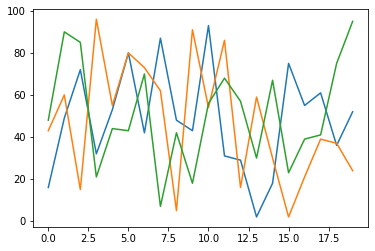

In [22]:
plt.figure()
plt.plot(np.argsort(pd_r1)[:20])
plt.plot(np.argsort(pd_mod)[:20])
plt.plot(np.argsort(pd_com)[:20])